In [1]:
import numpy as np
import pickle
import itertools
from scipy import stats
import scikit_posthocs as sp
import pandas as pd

In [38]:
%autoreload 2

In [37]:
from ensemble_functions import ensemble_epoch, ens_prob_trial, each_ens_stats, get_CV_classifiers, mean_ens, cdec_corr_by_trial, get_CV_classifiers_ens
from ensemble_plots import plot_trial_ensemble_matrix, plot_prob_ens_epoch_trial, classifier_box_plot_ens,plot_mean_activity_trials
from ensemble_plots import plot_mean_ensemble_activity

In [3]:
from smooth import smooth

In [89]:
group = 'Group_43/'
mouse_name = 'm212_'
date = '121521_'
session = '15_NLW'
condition = 'rMO_Cdec03_better'

store_location = '/Volumes/vazirilab_medium_data/francisca_martinez/Timing_Behavior/Behavioral_Data/' + group + date + session + '/' + mouse_name + condition + '_new'

In [92]:
trials_filename = store_location + '/' + mouse_name + date + session +'_trials_dict.pkl'
trials_dict = pickle.load(open(trials_filename, 'rb'))
data_filename = store_location + '/' + mouse_name + date + session +'_data_dict.pkl'    
data_dict = pickle.load(open(data_filename, 'rb'))
ens_filename = store_location + '/' + mouse_name + date + session +'_ensemble_data_dict.pkl' 
ens_dict = pickle.load(open(ens_filename, 'rb'))
axis_filename = store_location + '/' + 'axis_dict.pkl' 
axis_dict = pickle.load(open(axis_filename, 'rb'))
epoch_dict_file = store_location + '/' + mouse_name + date + session + '_epoch_dict.pkl'
epoch_dict = pickle.load(open(epoch_dict_file, "rb"))

In [6]:
aCdec = data_dict['aCdec_rMO']
zaFdff = data_dict['zaFdff_rMO']
shu_aCdec = data_dict['shu_aCdec_rMO']
shu_zaFdff = data_dict['shu_zaFdff_rMO']
zero = data_dict['zero']
tone_frames = data_dict['tone_frames']
resp_time = data_dict['response_time']
ens = np.arange(ens_dict["ens_trials"].shape[0]+1)
corr_cell_trials = ens_dict['corr_cell_trials']
core_cells = ens_dict['core_cells']

In [7]:
data_type = ['', 'shu_']
types = ['short', 'long']
ctypes = ['sc', 'lc']
itypes = ['si', 'li']
alltypes = ['sc', 'lc', 'si', 'li']

Separate the ensemble data for each behavioral epoch for each trial

In [8]:
ens_epoch_dict = {}
for dat in data_type:
    ens_matrix = ens_dict[f"{dat}ens_trials"]
    for tc in alltypes:
        ens_epoch_dict[f"{tc}_{dat}ens_interval"], \
        ens_epoch_dict[f"{tc}_{dat}ens_delay"], \
        ens_epoch_dict[f"{tc}_{dat}ens_resp"]= ensemble_epoch(ens_matrix, epoch_dict[f"mean_{tc}_interval"], 
                                                         epoch_dict[f"mean_{tc}_servo"], tone_frames, 
                                                         resp_time, trials_dict[f"{tc}_trials"])

[0 1 2 3 4]
[0 1 2 3 4]


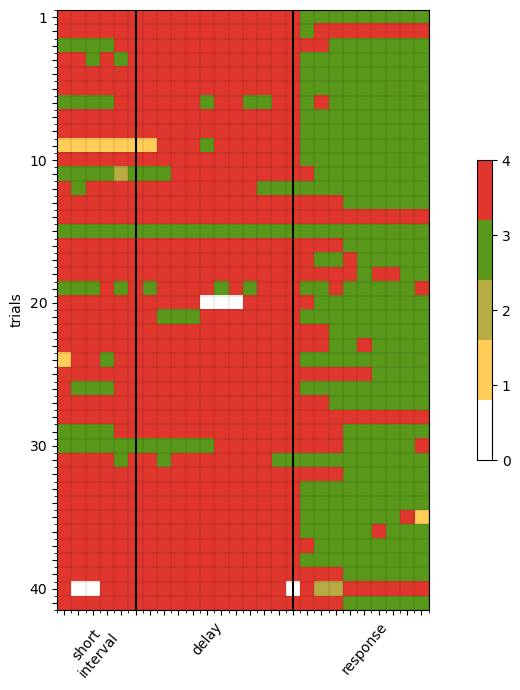

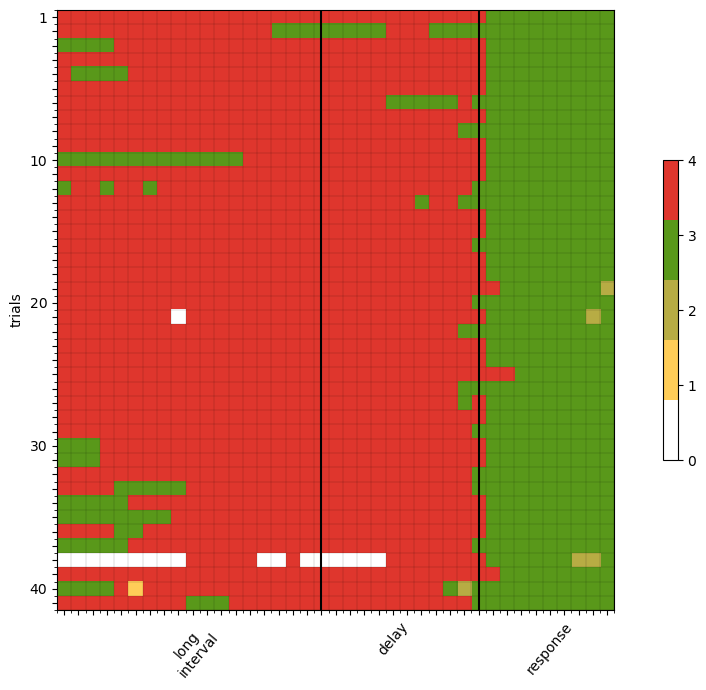

In [9]:
colors_ens_list = ['white', '#FFCD58', '#B7AC44', '#59981A','#DF362D']
for tc in ctypes:
    plot_trial_ensemble_matrix(ens_epoch_dict[f"{tc}_ens_interval"], ens_epoch_dict[f"{tc}_ens_delay"], 
                               ens_epoch_dict[f"{tc}_ens_resp"], epoch_dict[f"mean_{tc}_interval"], 
                               epoch_dict[f"mean_{tc}_servo"], axis_dict[f'x_{tc}_axis'], axis_dict['y_axis'], colors_ens_list)

**Probability of ensemble per epoch per trial type and for each trial**

In [10]:
## Probability of ensemble short and long correct trials
epochs = ['interval', 'delay', 'resp']
ens_cnts_dict = {}
ens_prob_dict = {}

for tc in ctypes:
    for ep, dat in itertools.product(epochs, data_type):
        ens_cnts_dict[f'{tc}_{dat}ens_{ep}'] = np.bincount(ens_epoch_dict[f"{tc}_ens_{ep}"].flatten().astype(int), minlength=len(ens))
        ens_prob_dict[f'{tc}_{dat}ens_{ep}'] = ens_cnts_dict[f'{tc}_{dat}ens_{ep}']/np.sum(ens_cnts_dict[f'{tc}_{dat}ens_{ep}'])
        ens_prob_dict[f'{tc}_{dat}ens_{ep}_trial'] = ens_prob_trial(ens_epoch_dict[f"{tc}_{dat}ens_{ep}"], ens)

ens_prob_dict['lc_short_ens_interval_trial'] = ens_prob_trial(ens_epoch_dict["lc_ens_interval"][:epoch_dict['mean_sc_interval'],:], ens)
ens_prob_dict['lc_short_shu_ens_interval_trial'] = ens_prob_trial(ens_epoch_dict["lc_shu_ens_interval"][:epoch_dict['mean_sc_interval'],:], ens)
      

In [11]:
p_value = 0.05

## determine the ensembles that are significantly more likely to be present during a 
## behavioral epoch compared to shuffled data
sc_ens_interval_p, sc_ens_interval_diff = each_ens_stats(ens_prob_dict['sc_ens_interval_trial'], 
                                                         ens_prob_dict['sc_shu_ens_interval_trial'])
sc_interval_ensembles = ens[sc_ens_interval_p<p_value]

sc_ens_delay_p, sc_ens_delay_diff = each_ens_stats(ens_prob_dict['sc_ens_delay_trial'], 
                                                   ens_prob_dict['sc_shu_ens_delay_trial'])
sc_delay_ensembles = ens[sc_ens_delay_p<p_value]

sc_ens_resp_p, sc_ens_delay_diff = each_ens_stats(ens_prob_dict['sc_ens_resp_trial'], 
                                                  ens_prob_dict['sc_shu_ens_resp_trial'])
sc_resp_ensembles = ens[sc_ens_resp_p<p_value]


sc_post_hoc_p_ens = np.ones((3,3,len(ens)))

for i in range(len(ens)):
    try:
        s, p = stats.kruskal(ens_prob_dict['sc_ens_interval_trial'][:,i], 
                             ens_prob_dict['sc_ens_delay_trial'][:,i], 
                             ens_prob_dict['sc_ens_resp_trial'][:,i])
    except ValueError:
        print('no differences for ensemble '+ str(i))
        continue
    if p <= p_value:
        post_p = sp.posthoc_dunn([ens_prob_dict['sc_ens_interval_trial'][:,i], 
                                  ens_prob_dict['sc_ens_delay_trial'][:,i], 
                                  ens_prob_dict['sc_ens_resp_trial'][:,i]], p_adjust = 'bonferroni')

        sc_post_hoc_p_ens[0,:, i] = post_p.iloc[0].to_numpy()
        sc_post_hoc_p_ens[1,:, i] = post_p.iloc[1].to_numpy()
        sc_post_hoc_p_ens[2,:, i] = post_p.iloc[2].to_numpy()

        
sc_p_values_df = pd.DataFrame({'interval_delay': np.ones((len(ens))),
                               'interval_resp': np.ones((len(ens))),
                               'delay_interval': np.ones((len(ens))),
                               'delay_resp': np.ones((len(ens))),
                               'resp_interval': np.ones((len(ens))),
                               'resp_delay': np.ones((len(ens)))})


for i in range(len(ens)):
    p_epochs = sc_post_hoc_p_ens[:,:,i]
    if sc_ens_interval_p[i]<= p_value:
        if p_epochs[0,1] <= p_value:
            sc_p_values_df['interval_delay'][i] = p_epochs[0,1]
        if p_epochs[0,2] <= p_value:
            sc_p_values_df['interval_resp'][i] = p_epochs[0,2]

    if sc_ens_delay_p[i] <= p_value:
        if p_epochs[1,0] <= p_value:
            sc_p_values_df['delay_interval'][i] = p_epochs[1,0]
        if p_epochs[1,2] <= p_value:
            sc_p_values_df['delay_resp'][i] = p_epochs[1,2]

    if sc_ens_resp_p[i] <= p_value:
        if p_epochs[2,0] <= p_value:
            sc_p_values_df['resp_interval'][i] = p_epochs[2,0]
        if p_epochs[2,1] <= p_value:
            sc_p_values_df['resp_delay'][i] = p_epochs[2,1]


sc_list_significant = []
sc_list_ens_sign = []
sc_p_values_df_binary = sc_p_values_df<=p_value
series_obj = sc_p_values_df_binary.any()
col_names = list(series_obj[series_obj == True].index)

for col in col_names:
    rows = list(sc_p_values_df_binary[col][sc_p_values_df_binary[col]== True].index)
    for row in rows:
        sc_list_significant.append((row, col))
        sc_list_ens_sign.append(row)
        
sc_ens_sigificant = np.unique(sc_list_ens_sign)
if sc_ens_sigificant[0] == 0:
    sc_ens_sigificant = sc_ens_sigificant[1:]
print('ensemble present during short correct trials =', sc_ens_sigificant)

ensemble present during short correct trials = [3 4]


/Users/franciscamartineztraub/Documents/GitHub/sensory_timing/neural_activity_analysis/timing_ensemble_analysis/ensemble_functions.py:47: RuntimeWarning: divide by zero encountered in divide
  diff = np.mean(each_ens_prob_trails, axis=0)/np.mean(each_ens_shu_prob_trails, axis=0)


Construct the the array for the probability of being present on each behavioral epoch for the significant ensembles

In [12]:
sc_epoch_label = ['short interval\nepoch', 'delay\nepoch','response\nepoch']

sc_ens_sign_prob = np.empty((len(sc_ens_sigificant), len(sc_epoch_label)))
sc_ens_sign_prob_sem = np.empty((len(sc_ens_sigificant), len(sc_epoch_label)))

for j, i in enumerate(sc_ens_sigificant):
    sc_ens_sign_prob[j, 0] = ens_prob_dict['sc_ens_interval'][i]
    sc_ens_sign_prob[j, 1] = ens_prob_dict['sc_ens_delay'][i]
    sc_ens_sign_prob[j, 2] = ens_prob_dict['sc_ens_resp'][i]
    
    sc_ens_sign_prob_sem[j, 0] = stats.sem(ens_prob_dict['sc_ens_interval_trial'][:,i])
    sc_ens_sign_prob_sem[j, 1] = stats.sem(ens_prob_dict['sc_ens_delay_trial'][:,i])
    sc_ens_sign_prob_sem[j, 2] = stats.sem(ens_prob_dict['sc_ens_resp_trial'][:,i])

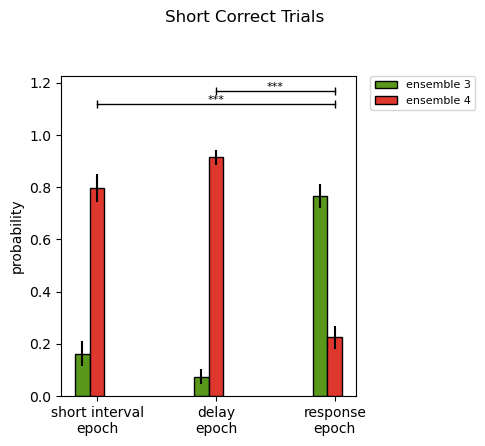

In [13]:
plot_prob_ens_epoch_trial(sc_ens_sign_prob, sc_ens_sign_prob_sem, sc_ens_sigificant, sc_p_values_df, 
                          sc_epoch_label, colors_ens_list, 'Short Correct Trials')

In [14]:
lc_ens_interval_p, lc_ens_interval_diff = each_ens_stats(ens_prob_dict['lc_ens_interval_trial'], 
                                                         ens_prob_dict['lc_shu_ens_interval_trial'])
lc_interval_ensembles = ens[lc_ens_interval_p<p_value]

lc_ens_delay_p, lc_ens_delay_diff = each_ens_stats(ens_prob_dict['lc_ens_delay_trial'], 
                                                   ens_prob_dict['lc_shu_ens_delay_trial'])
lc_delay_ensembles = ens[lc_ens_delay_p<p_value]

lc_ens_resp_p, lc_ens_delay_diff = each_ens_stats(ens_prob_dict['lc_ens_resp_trial'], 
                                                  ens_prob_dict['lc_shu_ens_resp_trial'])
lc_resp_ensembles = ens[lc_ens_resp_p<p_value]

lc_ens_short_interval_p, lc_ens_short_interval_diff = each_ens_stats(ens_prob_dict['lc_short_ens_interval_trial'], 
                                                                     ens_prob_dict['lc_short_shu_ens_interval_trial'])
lc_short_interval_ensembles = ens[lc_ens_short_interval_p<p_value]

lc_post_hoc_p_ens = np.ones((3,3,len(ens)))

for i in range(len(ens)):
    try:
        s, p = stats.kruskal(ens_prob_dict['lc_ens_interval_trial'][:,i], 
                             ens_prob_dict['lc_ens_delay_trial'][:,i], 
                             ens_prob_dict['lc_ens_resp_trial'][:,i])
    except ValueError:
        print('no differences for ensemble '+ str(i))
        continue
    if p <= p_value:
        post_p = sp.posthoc_dunn([ens_prob_dict['lc_ens_interval_trial'][:,i], 
                                  ens_prob_dict['lc_ens_delay_trial'][:,i], 
                                  ens_prob_dict['lc_ens_resp_trial'][:,i]], p_adjust = 'bonferroni')

        lc_post_hoc_p_ens[0,:, i] = post_p.iloc[0].to_numpy()
        lc_post_hoc_p_ens[1,:, i] = post_p.iloc[1].to_numpy()
        lc_post_hoc_p_ens[2,:, i] = post_p.iloc[2].to_numpy()

        
lc_p_values_df = pd.DataFrame({'interval_delay': np.ones((len(ens))),
                               'interval_resp': np.ones((len(ens))),
                               'delay_interval': np.ones((len(ens))),
                               'delay_resp': np.ones((len(ens))),
                               'resp_interval': np.ones((len(ens))),
                               'resp_delay': np.ones((len(ens)))})


for i in range(len(ens)):
    p_epochs = lc_post_hoc_p_ens[:,:,i]
    if lc_ens_interval_p[i]<= p_value:
        if p_epochs[0,1] <= p_value:
            lc_p_values_df['interval_delay'][i] = p_epochs[0,1]
        if p_epochs[0,2] <= p_value:
            lc_p_values_df['interval_resp'][i] = p_epochs[0,2]

        
    if lc_ens_delay_p[i] <= p_value:
        if p_epochs[1,0] <= p_value:
            lc_p_values_df['delay_interval'][i] = p_epochs[1,2]
        if p_epochs[1,2] <= p_value:
            lc_p_values_df['delay_resp'][i] = p_epochs[1,2]

    if lc_ens_resp_p[i] <= p_value:
        if p_epochs[2,0] <= p_value:
            lc_p_values_df['resp_interval'][i] = p_epochs[2,0]
        if p_epochs[2,1] <= p_value:
            lc_p_values_df['resp_delay'][i] = p_epochs[2,1]


lc_list_significant = []
lc_list_ens_sign = []
lc_p_values_df_binary = lc_p_values_df<=p_value
series_obj = lc_p_values_df_binary.any()
col_names = list(series_obj[series_obj == True].index)

for col in col_names:
    rows = list(lc_p_values_df_binary[col][lc_p_values_df_binary[col]== True].index)
    for row in rows:
        lc_list_significant.append((row, col))
        lc_list_ens_sign.append(row)
        
lc_ens_sigificant = np.unique(lc_list_ens_sign)
if lc_ens_sigificant[0]==0:
    lc_ens_sigificant = lc_ens_sigificant[1:]
print('ensemble present during long correct trials =', lc_ens_sigificant)

ensemble present during long correct trials = [3 4]


In [15]:
lc_epoch_label = ['long interval\nepoch', 'delay\nepoch','response\nepoch']

lc_ens_sign_prob = np.empty((len(lc_ens_sigificant), len(lc_epoch_label)))
lc_ens_sign_prob_sem = np.empty((len(lc_ens_sigificant), len(lc_epoch_label)))

for j, i in enumerate(lc_ens_sigificant):
    lc_ens_sign_prob[j, 0] = ens_prob_dict['lc_ens_interval'][i]
    lc_ens_sign_prob[j, 1] = ens_prob_dict['lc_ens_delay'][i]
    lc_ens_sign_prob[j, 2] = ens_prob_dict['lc_ens_resp'][i]
    
    lc_ens_sign_prob_sem[j, 0] = stats.sem(ens_prob_dict['lc_ens_interval_trial'][:,i])
    lc_ens_sign_prob_sem[j, 1] = stats.sem(ens_prob_dict['lc_ens_delay_trial'][:,i])
    lc_ens_sign_prob_sem[j, 2] = stats.sem(ens_prob_dict['lc_ens_resp_trial'][:,i])

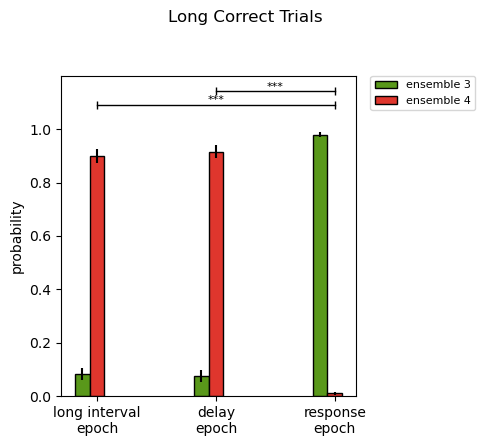

In [16]:
plot_prob_ens_epoch_trial(lc_ens_sign_prob, lc_ens_sign_prob_sem, lc_ens_sigificant, lc_p_values_df, 
                          lc_epoch_label, colors_ens_list, 'Long Correct Trials')

In [17]:
## Compare the first 0.5s of each trial type
ens_short_interval_s, ens_short_interval_p = stats.mannwhitneyu(ens_prob_dict['sc_ens_interval_trial'], 
                                                                ens_prob_dict['lc_short_ens_interval_trial'])

print(ens_short_interval_p[sc_interval_ensembles]<=p_value)

short_p_values_df = pd.DataFrame({'interval_delay': np.ones((len(ens))),
                                  'interval_resp': np.ones((len(ens))),
                                  'delay_interval': np.ones((len(ens))),
                                  'delay_resp': np.ones((len(ens))),
                                  'resp_interval': np.ones((len(ens))),
                                  'resp_delay': np.ones((len(ens)))})
for i in range(len(ens)):
    short_p_values_df['interval_delay'][i] = ens_short_interval_p[i]
    
short_epoch_label = ['short interval\nepoch', 'truncated\nlong interval\nepoch']
short_ens_sign_prob = np.empty((len(sc_ens_sigificant), len(short_epoch_label)))
short_ens_sign_prob_sem = np.empty((len(sc_ens_sigificant), len(short_epoch_label)))

for j, i in enumerate(sc_ens_sigificant):
    short_ens_sign_prob[j, 0] = np.mean(ens_prob_dict['sc_ens_interval_trial'][:,i])
    short_ens_sign_prob[j, 1] = np.mean(ens_prob_dict['lc_short_ens_interval_trial'][:,i])
    
    short_ens_sign_prob_sem[j, 0] = stats.sem(ens_prob_dict['sc_ens_interval_trial'][:,i])
    short_ens_sign_prob_sem[j, 1] = stats.sem(ens_prob_dict['lc_short_ens_interval_trial'][:,i])



[False False False]


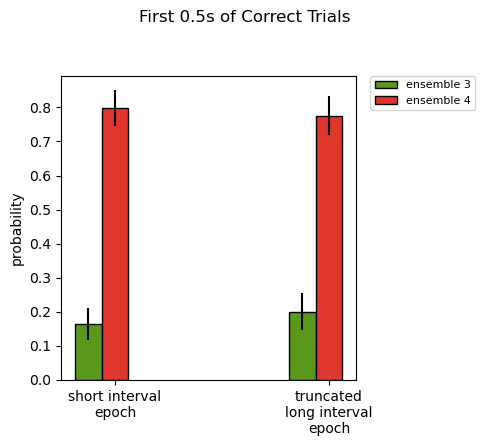

In [18]:
plot_prob_ens_epoch_trial(short_ens_sign_prob, short_ens_sign_prob_sem, sc_ens_sigificant, short_p_values_df, 
                          short_epoch_label, colors_ens_list, 'First 0.5s of Correct Trials')

In [19]:
sig_ensembles = np.unique(np.concatenate([sc_ens_sigificant,lc_ens_sigificant]))
print('the ensembles that are interesting are', sig_ensembles)

the ensembles that are interesting are [3 4]


In [20]:
Dict_class_ens = {}
svm_data = []
svm_data_shu = []
svm_p_value = []


for i,j in enumerate(ens[1:]):
    cell_name = f"cell_ens_{j}"
    Dict_class_ens[cell_name] = np.where(core_cells[:,i]==True)[0]
    Dict_class_ens[f"cell_class_{j}"] = get_CV_classifiers(aCdec[Dict_class_ens[cell_name],:,:],
                                                             shu_aCdec[Dict_class_ens[cell_name],:,:],
                                                             zero, epoch_dict['mean_sc_interval'], 
                                                             epoch_dict['mean_lc_interval'], 
                                                             trials_dict["sc_trials"], trials_dict["lc_trials"])
    svm_data.append(Dict_class_ens[f"cell_class_{j}"]['CV_svm'])
    svm_data_shu.append(Dict_class_ens[f"cell_class_{j}"]['CV_svm_shu'])
    svm_p_value.append(Dict_class_ens[f"cell_class_{j}"]['p_value_svm'])


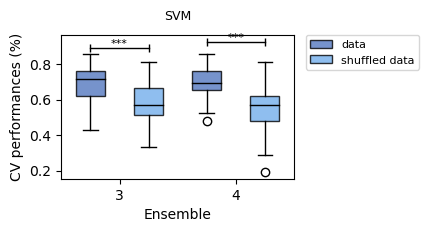

In [21]:
labels = sig_ensembles.astype('str')
svm_dat_cv = np.array(svm_data)[sig_ensembles-1].tolist()
svm_shu_cv = np.array(svm_data_shu)[sig_ensembles-1].tolist()
svm_p = np.array(svm_p_value)[sig_ensembles-1]

classifier_box_plot_ens(labels, svm_dat_cv, svm_shu_cv, svm_p)

In [22]:
int_ensemble = 4
rew_ensemble = 3 
int_cells = Dict_class_ens['cell_ens_4'][:-1]
rew_cells = Dict_class_ens['cell_ens_3']

In [23]:
int_corr_cell_trials = corr_cell_trials[:,int_ensemble-1,:]
rew_corr_cell_trials = corr_cell_trials[:,rew_ensemble-1,:]
Cdec_bin = np.zeros_like((aCdec))
Cdec_bin[aCdec>=0.3] = 1
shu_Cdec_bin = np.zeros_like((shu_aCdec))
shu_Cdec_bin[shu_Cdec_bin>=0.3] = 1

In [24]:
all_trials = np.sort(np.concatenate((trials_dict['sc_trials'], trials_dict['lc_trials'], 
                                     trials_dict['si_trials'], trials_dict['li_trials'])))

In [25]:
Cdec_int_trials = {}
Cdec_rew_trials = {}
for tc in alltypes:
    t = trials_dict[f'{tc}_trials']

    Cdec_int_trials[f'Cdec_int_{tc}'] = cdec_corr_by_trial(Cdec_bin, int_corr_cell_trials, t, all_trials)
    Cdec_rew_trials[f'Cdec_rew_{tc}'] = cdec_corr_by_trial(Cdec_bin, rew_corr_cell_trials, t, all_trials)

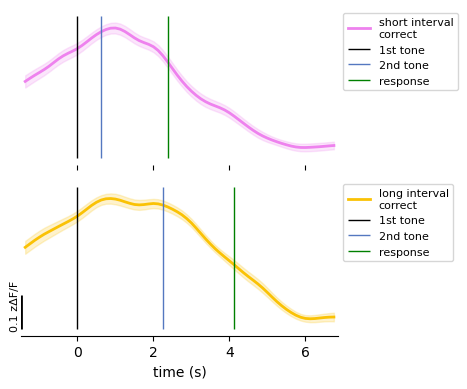

In [26]:
plot_mean_ensemble_activity([11,66], zero, Cdec_int_trials, 'Cdec_int', epoch_dict)

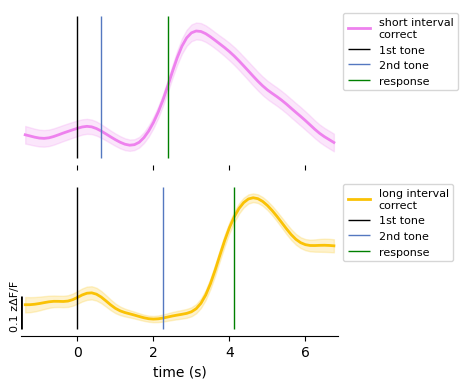

In [27]:
plot_mean_ensemble_activity([11,66], zero, Cdec_rew_trials, 'Cdec_rew', epoch_dict)

In [28]:
rest_cells = np.arange(aCdec.shape[0])
rew_int_cells = np.unique(np.concatenate([int_cells, rew_cells]))
rest_cells = np.delete(rest_cells, rew_int_cells)

share_int_rew, int_idx, rew_idx = np.intersect1d(int_cells, rew_cells, assume_unique=True, return_indices=True)
int_unique_cells = np.delete(int_cells, int_idx)
rew_unique_cells = np.delete(rew_cells, rew_idx)

In [29]:
corr_cell_trials.shape

(414, 4, 97)

In [56]:
Dict_class_ens_int = {}
Dict_class_ens_rew = {}
Dict_class_ens_rest = {}
Dict_class_ens_uint = {}
Dict_class_ens_urew = {}
mean_epoch = epoch_dict['mean_lc_interval'] + epoch_dict['mean_lc_servo']
condition = ['normal', 'shuffle', 'align']

for c in condition:
    Dict_class_ens_int[f'{c}_dict'] = get_CV_classifiers_ens(Cdec_bin, shu_Cdec_bin, int_cells, int_corr_cell_trials,
                                                            trials_dict['sc_trials'], trials_dict['lc_trials'], [zero,zero], mean_epoch, c)
    Dict_class_ens_rew[f'{c}_dict'] = get_CV_classifiers_ens(Cdec_bin, shu_Cdec_bin, rew_cells, rew_corr_cell_trials, 
                                                            trials_dict['sc_trials'], trials_dict['lc_trials'], [zero,zero], mean_epoch, c)
    Dict_class_ens_rest[f'{c}_dict'] = get_CV_classifiers_ens(Cdec_bin, shu_Cdec_bin, rest_cells, corr_cell_trials[:,0,:], 
                                                            trials_dict['sc_trials'], trials_dict['lc_trials'], [zero,zero], mean_epoch, c)


    Dict_class_ens_uint[f'{c}_dict'] = get_CV_classifiers_ens(Cdec_bin, shu_Cdec_bin, int_unique_cells, int_corr_cell_trials, 
                                                            trials_dict['sc_trials'], trials_dict['lc_trials'], [zero,zero], mean_epoch, c)
    Dict_class_ens_urew[f'{c}_dict'] = get_CV_classifiers_ens(Cdec_bin, shu_Cdec_bin, rew_unique_cells, rew_corr_cell_trials, 
                                                            trials_dict['sc_trials'], trials_dict['lc_trials'], [zero,zero], mean_epoch, c)


/Users/franciscamartineztraub/Documents/GitHub/sensory_timing/neural_activity_analysis/timing_ensemble_analysis/ensemble_functions.py:140: RuntimeWarning: Mean of empty slice
  elif condition == 'align':
/Users/franciscamartineztraub/Documents/GitHub/sensory_timing/neural_activity_analysis/timing_ensemble_analysis/ensemble_functions.py:145: RuntimeWarning: Mean of empty slice
  return Cdec_corr_trials
/Users/franciscamartineztraub/Documents/GitHub/sensory_timing/neural_activity_analysis/timing_ensemble_analysis/ensemble_functions.py:150: RuntimeWarning: Mean of empty slice


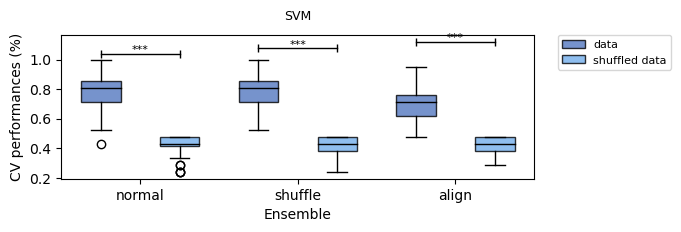

In [63]:
labels = ['normal', 'shuffle', 'align']
svm_dat_cv = [Dict_class_ens_int['normal_dict']['CV_svm'], 
              Dict_class_ens_int['shuffle_dict']['CV_svm'], 
              Dict_class_ens_int['align_dict']['CV_svm']]
svm_shu_cv = [Dict_class_ens_int['normal_dict']['CV_svm_shu'],
                Dict_class_ens_int['shuffle_dict']['CV_svm_shu'], 
              Dict_class_ens_int['align_dict']['CV_svm_shu']]
svm_p_values = [Dict_class_ens_int['normal_dict']['p_value_svm'],
                Dict_class_ens_int['shuffle_dict']['p_value_svm'],
                Dict_class_ens_int['align_dict']['p_value_svm']]

classifier_box_plot_ens(labels, svm_dat_cv, svm_shu_cv, svm_p_values)

In [60]:
Dict_class_ens_int_2 = {}
Dict_class_ens_rew_2 = {}
Dict_class_ens_rest_2 = {}
Dict_class_ens_uint_2 = {}
Dict_class_ens_urew_2 = {}
sc_resp_zero = zero + epoch_dict['mean_sc_interval'] + epoch_dict['mean_sc_servo'] + epoch_dict['mean_sc_resp']-1
lc_resp_zero = zero + epoch_dict['mean_lc_interval'] + epoch_dict['mean_lc_servo'] + epoch_dict['mean_lc_resp']-1
mean_epoch = 16
condition = ['normal', 'shuffle', 'align']

for c in condition:
    Dict_class_ens_int_2[f'{c}_dict'] = get_CV_classifiers_ens(Cdec_bin, shu_Cdec_bin, int_cells, int_corr_cell_trials,
                                                            trials_dict['sc_trials'], trials_dict['lc_trials'], [sc_resp_zero, lc_resp_zero], mean_epoch, c)
    Dict_class_ens_rew_2[f'{c}_dict'] = get_CV_classifiers_ens(Cdec_bin, shu_Cdec_bin, rew_cells, rew_corr_cell_trials, 
                                                            trials_dict['sc_trials'], trials_dict['lc_trials'], [sc_resp_zero, lc_resp_zero], mean_epoch, c)
    Dict_class_ens_rest_2[f'{c}_dict'] = get_CV_classifiers_ens(Cdec_bin, shu_Cdec_bin, rest_cells, corr_cell_trials[:,0,:], 
                                                            trials_dict['sc_trials'], trials_dict['lc_trials'], [sc_resp_zero, lc_resp_zero], mean_epoch, c)


    Dict_class_ens_uint_2[f'{c}_dict'] = get_CV_classifiers_ens(Cdec_bin, shu_Cdec_bin, int_unique_cells, int_corr_cell_trials, 
                                                            trials_dict['sc_trials'], trials_dict['lc_trials'], [sc_resp_zero, lc_resp_zero], mean_epoch, c)
    Dict_class_ens_urew_2[f'{c}_dict'] = get_CV_classifiers_ens(Cdec_bin, shu_Cdec_bin, rew_unique_cells, rew_corr_cell_trials, 
                                                            trials_dict['sc_trials'], trials_dict['lc_trials'], [sc_resp_zero, lc_resp_zero], mean_epoch, c)


/Users/franciscamartineztraub/Documents/GitHub/sensory_timing/neural_activity_analysis/timing_ensemble_analysis/ensemble_functions.py:140: RuntimeWarning: Mean of empty slice
  elif condition == 'align':
/Users/franciscamartineztraub/Documents/GitHub/sensory_timing/neural_activity_analysis/timing_ensemble_analysis/ensemble_functions.py:145: RuntimeWarning: Mean of empty slice
  return Cdec_corr_trials
/Users/franciscamartineztraub/Documents/GitHub/sensory_timing/neural_activity_analysis/timing_ensemble_analysis/ensemble_functions.py:150: RuntimeWarning: Mean of empty slice


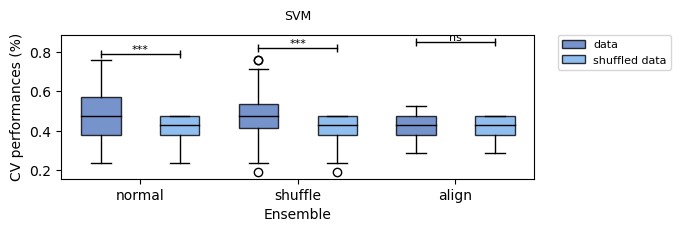

In [62]:
labels = ['normal', 'shuffle', 'align']
svm_dat_cv = [Dict_class_ens_rew_2['normal_dict']['CV_svm'], 
              Dict_class_ens_rew_2['shuffle_dict']['CV_svm'], 
              Dict_class_ens_rew_2['align_dict']['CV_svm']]
svm_shu_cv = [Dict_class_ens_rew_2['normal_dict']['CV_svm_shu'],
                Dict_class_ens_rew_2['shuffle_dict']['CV_svm_shu'], 
              Dict_class_ens_rew_2['align_dict']['CV_svm_shu']]
svm_p_values = [Dict_class_ens_rew_2['normal_dict']['p_value_svm'],
                Dict_class_ens_rew_2['shuffle_dict']['p_value_svm'],
                Dict_class_ens_rew_2['align_dict']['p_value_svm']]

classifier_box_plot_ens(labels, svm_dat_cv, svm_shu_cv, svm_p_values)